# Prototype code for Coder Speciation class

The SimpleSolnModel class will be extended as outlined below:
- Basis and non-basis (dependent species) endmember properties are defined using StdStateMdel
- A SpeciationSolnModel class is initialized with $c$ components (basis species) and $s$ non-basis species
- A model expression for the Gibbs free energy of solution is added that depends only on $T$, $P$, and mole numbers of the basis components
  - This expression should be optimzed to make compositional derivatives as compact as possible. This will dramatically lesson code generation and compilation time.
- When the class is code printed it generates the speciation code at the cython level, using scipy.optimize.minimize as a solver.  Eventually, this method should be replaced by a pure C implementation so that the code can be cleanly exported. 
  - A flag should be added to the class to avoid generation of compositional derivative code that is not currently used by the Equilibrate class
  - Only the bold derivatives in the list below are required.  The rest are optional.   Modifications should be done in the `create_soln_calc_h_file` of the SpeciationSolnModel class
  - dn_g_list: **dgdn**, **d2gdndt**, **d2gdndp**, **d3gdndt2**, **d3gdndtdp**, **d3gdndp2**, d4gdndt3, d4gdndt2dp, d4gdndtdp2, d4gdndp3  
  - d2n_g_list: **d2gdn2**, **d3gdn2dt**, **d3gdn2dp**, d4gdn2dt2, d4gdn2dtdp, d4gdn2dp2, d5gdn2dt3, d5gdn2dt2dp, d5gdn2dtdp2, d5gdn2dp3  
  - d3n_g_list: **d3gdn3**, d4gdn3dt, d4gdn3dp, d5gdn3dt2, d5gdn3dtdp, d5gdn3dp2, d6gdn3dt3, d6gdn3dt2dp, d6gdn3dtdp2, d6gdn3dp3
- Question that needs to be addressed is how does this algorithm scale?  
 - Will generation and compilation be too slow for 10 basis components and say 100 non-basis species?
 - Will the scipy.optimize.minimize method converge as quickly or as often as the number of basis species increases?
 - Should we insert tests for speciation convergence and abort the computation if these fail?

In [1]:
# time code
import time
t0 = time.time()

In [2]:
import numpy as np
import pandas as pd
from os import path, listdir
import scipy.optimize as opt
import sys
import fileinput
import sympy as sym
import itertools
from thermoengine import coder, core, phases, model, equilibrate
sym.init_printing()

In [3]:
# needed for fitting Haas/Fischer
from scipy.optimize import curve_fit

# needed for Cp polynomial fitting
import numpy.polynomial.polynomial as poly

# Gas Endmembers (coder)

In [4]:
t = 1700  # K
p = 1e-4  # bars
module_type = 'calib' # 'fast' or 'calib'

global_method = "poly" # 'poly', 'hf', 'hkf'(experimental)
global_ncoeffs = 6 # terms in polynomial Cp fit
global_minimum = 900
global_maximum = 2100
global_fit = 'Cp' # 'Cp' or 'Gef'

basis_list = ['Al1', 'Fe1', 'Na1', 'C1', 'N1', 'O1', 'H1', 'He1', 'Ne1', 'Ar1', 'Ca1', 'Si1', 'Ti1', 'S1', 'Mg1']
#basis_list = ['Al1', 'O1', 'H1', 'He1', 'Ne1', 'Ar1', 'Ca1']

# basis_list = ["H1", "He1",
#               "C1", "N1", "O1", "F1", "Ne1",
#               "Na1", "Mg1", "Al1", "Si1", "P1", "S1", "Cl1", "Ar1",
#               "K1", "Ca1", "Ti1", "Cr1", "Mn1", "Fe1", "Co1", "Ni1"]



# basis_list = ['H', 'He', 'O', 'Ne', 'Al', 'Si', 'S', 'Ar', 'Ca', 'Ti', 'Mg']

basis_list = ['O1', 'Al1', 'Ca1', 'H1', 'Ne1', 'Ar1', 'He1', 'Ti1', 'Mg1']

In [5]:
# needed for melts model v 1
# basis_list = ['Si1','Ti1','Al1','Fe1','Cr1','Fe1','Mn1','Mg1','Ni1','Co1','Ca1','Na1','K1','P1','H1','O1']

# needed for melts model v 1.2.0
# basis_list = ['Si1','Ti1','Al1','Fe1','Cr1','Fe1','Mn1','Mg1','Ni1','Co1','Ca1','Na1','K1','P1','H1','C1','O1']

# Helper functions

In [6]:
basis_list

['O1', 'Al1', 'Ca1', 'H1', 'Ne1', 'Ar1', 'He1', 'Ti1', 'Mg1']

### Functions to fit JANAF table Cp values

In [7]:
janaf_gases = [f.replace(".txt", "") for f in listdir("data/gases") if '.txt' in f and 'Br' not in f] # condition excludes python checkpoint files
knacke_1991_gases = ['Cl2Cr1', 'Cl2Cr1O2', 'Cr1S1', 'F2Mn1', 'Cl2Mn1', 'S1Ti1', 'Ni1O1']

# Haas/Fischer heat capacity equation (not used)
def HF_cp(T, a, b, c, f, g):
    return a + b*T + c*T**(-2) + f*T**2 + g*T**(-0.5)

def HKF_Gef(T, a, b, c, d, e, f):
    return a + b*T + c*T**(-2) + d*T**2 + e*T**(-0.5) + f*T**(-3)

# get list of temps and corresponding Cps, as well as S_TrPr and H_TrPr
def get_thermo_values(formula, minimum=298.15, maximum=6000, ncoeffs=15, method="poly", fit="Cp"):
    
    if formula in janaf_gases:
        source = "JANAF"
    elif formula in knacke_1991_gases:
        source = "Knacke_et_al_1991"
        
    
    if source == "JANAF":
        folder="data/gases/"
        phase = ""
        
        # open the JANAF table csv
        df = pd.read_csv(folder+formula+".txt", skiprows=[0], sep='\t', error_bad_lines=False)
        
        # get df index of reference temperature
        ref_indx = df.index[df['T(K)'] == 298.15].tolist()
        
        
        try:
            # get df index of 0K
            ref_indx_0 = df.index[df['T(K)'] == 0].tolist()
            
            # get H_TrPr (negative value of H-H(Tr) at 0K)
            H_TrPr = -float(df["H-H(Tr)"][ref_indx_0[0]])*1000 # kJ to joules
            
            
            
        except:
            # get df index of 2000K
            indx_2000 = df.index[df['T(K)'] == 2000].tolist()
            T_vals = df["T(K)"][ref_indx[0]:indx_2000[0]+1].tolist()
            HH_vals = df["H-H(Tr)"][ref_indx[0]:indx_2000[0]+1].tolist()
            
            # extrapolate H_TrPr using polyfit (2 coefs)
            HH_0K = poly.polyfit(T_vals, HH_vals, 2)[0] # first coeff of polyfit is H-H(Tr) at 0K
            H_TrPr = -HH_0K*1000 # get H_TrPr (negative value of H-H(Tr) at 0K)
            
        ### TEST ###
        H_TrPr = float(df["delta-f H"][ref_indx[0]])*1000 # kJ to joules
        
        S_TrPr = float(df["S"][ref_indx[0]])
        
        if minimum > 298.15:
            try:
                min_indx = df.index[df['T(K)'] == minimum].tolist()
            except:
                print("Error! Could not find an index in", formula, "JANAF table for user-specified temperature minimum of", str(minimum), "degrees K.")
        else:
            min_indx = ref_indx
        
        # extract temperature and heat capacity values
        if maximum != 6000:
            try:
                # get index of max desired temperature
                max_indx = df.index[df['T(K)'] == maximum].tolist()
                
                # get Ts and Cps including and below max desired temp
                T_vals = df["T(K)"][min_indx[0]:max_indx[0]+1].tolist()
                if fit == "Cp":
                    fit_vals = df["Cp"][min_indx[0]:max_indx[0]+1].tolist()
                elif fit == "Gef":
                    fit_vals = df["-[G-H(Tr)]/T"][min_indx[0]:max_indx[0]+1].tolist()
                else:
                    print("Error! Fit requires Cp or Gef.")
                fit_vals = [float(val) for val in fit_vals]
        
            except:
                print("Error! Could not find an index in", formula, "JANAF table for user-specified temperature maximum of", str(maximum), "degrees K.")
        else:
            # get Ts and Cps
            T_vals = df["T(K)"][min_indx[0]:].tolist()
            if fit == "Cp":
                fit_vals = df["Cp"][min_indx[0]:].tolist()
            elif fit == "Gef":
                fit_vals = df["-[G-H(Tr)]/T"][min_indx[0]:].tolist()
            else:
                print("Error! Fit requires Cp or Gef.")
            fit_vals = [float(val) for val in fit_vals]

    # handle gases from Knacke et al. 1991
    elif source == "Knacke_et_al_1991":
        # open data source
        path = open("data/knacke1991.txt")
        
        # extract data
        molecule = ""
        for temp in path:
            values = temp.split('\t')
            if values[0]==formula:
                molecule = values
        if molecule == "":
            print("Error: Could not find formula", formula, "in Knacke et al 1991 database.")
        
        # retrieve reference enthalpy and entropy
        H_TrPr = float(molecule[2])
        S_TrPr = float(molecule[3])
        
        # define the heat capacity expression
        T = define_T()
        A, B, C = sym.symbols("A B C")
        expr = (A + B*T + C*T**-2).subs({'H_TrPr':H_TrPr,
                                         'S_TrPr':S_TrPr,
                                         'A':float(molecule[4]),
                                         'B':float(molecule[5])*1e-3,
                                         'C':float(molecule[6])*1e6})
        
        # produce a list of temps mimicking those reported in JANAF tables
        T_vals = [298.15] + list(range(300, 1000, 50)) + list(range(1000, 6100, 100))
        
        if minimum != 298.15:
            # get index of min desired temperature
            min_indx = T_vals.index(minimum)
            T_vals = T_vals[min_indx:]
        
        if maximum != 6000:
            # get index of max desired temperature
            max_indx = T_vals.index(maximum)
            T_vals = T_vals[:max_indx+1]
        
        
        fit_vals = [float(expr.subs({'T':temp})) for temp in T_vals]
        
    return T_vals, fit_vals, S_TrPr, H_TrPr


# fit data as a function of T
def fit_data(T_vals, fit_vals, method="poly", ncoeffs=15):
    
    if method == "poly":
        coefs = poly.polyfit(T_vals, fit_vals, ncoeffs) # polynomial
    elif method == "hf":
        coefs, pcov = curve_fit(HF_cp, T_vals, fit_vals) # Haas/Fischer
    else:
        print("Error: '"+method+"' is not a recognized fitting method!")
    
    #coefs = [float('{:0.3e}'.format(coef)) for coef in coefs] # reduce the number of reported digits
    
    return coefs

### Create expression for Cp fit

In [8]:
def define_T():
    return sym.symbols('T') # eventually replaced with model.get_symbol_for_t()
def define_P():
    return sym.symbols('P') # eventually replaced with model.get_symbol_for_t()

# create a polynomial Cp expression
def create_CpPr_expression(method="poly", ncoeffs=15):
    T = define_T()
    
    if method == "poly":
        CpPr = sym.symbols('k0')
        for i in range(1, ncoeffs+1):
            this_coeff = sym.symbols('k'+str(i))
            CpPr += this_coeff*T**i

    elif method == "hf":
        # Haas/Fischer
        a, b, c, f, g = sym.symbols('k0 k1 k2 k3 k4')
        CpPr = a + b*T + c*T**(-2) + f*T**2 + g/T**0.5
    
    else:
        print("Error: '"+method+"' is not a recognized Cp fitting method!")
        
    return CpPr

CpPr = create_CpPr_expression(ncoeffs=global_ncoeffs, method=global_method)
CpPr

### Create expression for apparent Gibbs free energy

In [9]:
# create GPr expression (1.89 minute write + compile for [O, Al, Ca])
def create_GPr_expression(ncoeffs=15, method="poly", fit="Cp"):
    
    if fit == 'Cp':
        CpPr = create_CpPr_expression(ncoeffs=ncoeffs, method=method)
        T = define_T()
        P = define_P()
        R = 8.31446261815324
        Tr,Pr = sym.symbols('T_r P_r') # eventually replaced with model.get_symbol_for_tr()
        STrPr,HTrPr = sym.symbols('S_TrPr H_TrPr')
        GPr = HTrPr + sym.integrate(CpPr,(T,Tr,T)) - T*(STrPr + sym.integrate(CpPr/T,(T,Tr,T)))
        GPr += R*T*sym.log(P)
        # #Alternatively, combining equations 2.8 and 2.9 from "ON THE GIBBS ENERGY AND
        # #CHEMICAL POTENTIALS OF AN IDEAL GAS MIXTURE" by Vlado A. Lubarda
        #GPr = (CpPr - (CpPr*sym.log(T/Tr) - R*sym.log(P/Pr) + STrPr))*T # resulting coded Cp function too wavy!
    
    elif fit == 'Gef':
        Gef = create_CpPr_expression(ncoeffs=ncoeffs, method=method)
        T = define_T()
        P = define_P()
        R = 8.31446261815324
        Tr = sym.symbols('T_r') # eventually replaced with model.get_symbol_for_tr()
        STrPr,HTrPr = sym.symbols('S_TrPr H_TrPr')
        GPr = -(Gef*T) + HTrPr
        GPr += R*T*sym.log(P)
        
    return GPr

GPr = create_GPr_expression(ncoeffs=global_ncoeffs, method=global_method, fit=global_fit)
GPr

### Create dictionary of parameters for free energy expression

In [10]:
def get_param_dict(compound, minimum=298.15, maximum=6000, ncoeffs=15, method="poly", fit="Cp"):
    T_vals, fit_vals, S_TrPr, H_TrPr = get_thermo_values(compound, minimum=minimum, maximum=maximum, fit=fit)
    coefs = fit_data(T_vals, fit_vals, method=method, ncoeffs=ncoeffs)
    
    param_dict = {}
    param_dict['k0'] = coefs[0]
    for i in range(1, len(coefs)):
        try:
            param_dict['k'+str(i)] = coefs[i]
        except:
            break
    param_dict.update({"T_r":298.15})
    param_dict.update({"P_r":1})
    param_dict.update({"S_TrPr":S_TrPr})
    param_dict.update({"H_TrPr":H_TrPr})
    return param_dict

Al2_param_dict_poly = get_param_dict("Al2", method="poly")
Al2_param_dict_hf = get_param_dict("Al2", method="hf")
TiS_param_dict = get_param_dict("S1Ti1", method="hf")

print("Al2 (JANAF) params, Polynomial:", Al2_param_dict_poly)
print("Al2 (JANAF) params, Haas/Fischer:", Al2_param_dict_hf)
print("TiS (Knacke et al 1991) params, Haas/Fischer:", TiS_param_dict)

Al2 (JANAF) params, Polynomial: {'k0': 18.1901877080998, 'k1': 0.09067641718022552, 'k2': 6.7970278211436774e-06, 'k3': -5.497791209790642e-07, 'k4': 1.2894604239929195e-09, 'k5': -1.6035848171955748e-12, 'k6': 1.2942677608139118e-15, 'k7': -7.2959552366423e-19, 'k8': 2.9720131567076504e-22, 'k9': -8.878276533153338e-26, 'k10': 1.9476282134170504e-29, 'k11': -3.1020954120156716e-33, 'k12': 3.490375600220861e-37, 'k13': -2.6297140850991143e-41, 'k14': 1.1902001329054644e-45, 'k15': -2.446162146827261e-50, 'T_r': 298.15, 'P_r': 1, 'S_TrPr': 233.53099999999998, 'H_TrPr': 487018.0}
Al2 (JANAF) params, Haas/Fischer: {'k0': 19.329848236374602, 'k1': 0.0040146640924794506, 'k2': -1654059.7139049205, 'k3': -1.2607215064936884e-07, 'k4': 627.5238413330104, 'T_r': 298.15, 'P_r': 1, 'S_TrPr': 233.53099999999998, 'H_TrPr': 487018.0}
TiS (Knacke et al 1991) params, Haas/Fischer: {'k0': 36.99500096598652, 'k1': 0.00022199972253421127, 'k2': -296999.95624963735, 'k3': 2.970663433852095e-14, 'k4': -2.

In [11]:
GPr.subs(get_param_dict("Al1", minimum=global_minimum, maximum=global_maximum, method="poly", ncoeffs=6, fit=global_fit)).subs({"T":1600, "P":1})

### chemical formula parsing functions (and misc functions)

In [12]:
import re

# function to return index of all instances of a substring in a string
def find_all(sub, a_str):
    start = 0
    while True:
        start = a_str.find(sub, start)
        if start == -1: return
        yield start
        start += len(sub) # use start += 1 to find overlapping matches

# functions to parse elemental formulas (handles both floats and ints)
# Does not currently handle parentheses: e.g. "NaB(OH)4" won't work
def get_first_elem(formula):
    needed_split = False
    for char in formula:
        if formula.find(char) != 0 and (char.isupper() or char == "+" or char == "-"):
            formula = formula.split(char)[0]
            needed_split = True
            return formula, needed_split
        
        char_ind = list(find_all(char, formula))
        if len(char_ind) > 1 and (char.isupper() or char == "+" or char == "-") and (formula[1] == char or formula[1].islower()):
            formula = formula[0:char_ind[1]]
            needed_split = True
            return formula, needed_split

    return formula, needed_split

In [13]:
def inner_parse_formula(text):
    formula_dict = {}     
    for i in range(0, len(text)):
        element = re.findall("^[a-zA-Z-+]+", text)
        if element == []:
            break
        else:
            element, needed_split = get_first_elem(element[0])
            text = text.replace(element, '', 1)
            if needed_split:
                number = 1.0
            else:
                try:
                    number = float(re.findall(r"(^(?=.)([+-]?([0-9]*)(\.([0-9]+))?)([eE][+-]?\d+)?)", text)[0][0])
                except:
                    number = 1.0
                text = re.sub(r"(^(?=.)([+-]?([0-9]*)(\.([0-9]+))?)([eE][+-]?\d+)?)", "", text)
            if element not in list(formula_dict.keys()):
                formula_dict[element] = number
            else:
                formula_dict[element] += number
    return formula_dict

def parse_formula(text):
    
    # handle parentheses in formula
    if "(" in text and ")" in text:
        parenth_list = re.findall(r"(?:\([^()]*\))?", text)
        parenth_list = [seg for seg in parenth_list if seg != '']
        seg_dict_list = []
        if len(parenth_list) != 0:
            for seg in parenth_list:
                try:
                    number = float(re.findall(r"(^(?=.)([+-]?([0-9]*)(\.([0-9]+))?)([eE][+-]?\d+)?)", text.split(seg)[-1])[0][0])
                except:
                    number = 1.0
                seg_no_parenth = seg[1:-1]
                seg_formula_dict = inner_parse_formula(seg_no_parenth)
                seg_formula_dict_mult = {k:v*number for (k,v) in seg_formula_dict.items()}
                endseg = re.sub(r"(^(?=.)([+-]?([0-9]*)(\.([0-9]+))?)([eE][+-]?\d+)?)", "", text.split(seg)[-1])
                text = text.split(seg)[0]+endseg
                seg_dict_list.append(seg_formula_dict_mult)
        seg_dict_list.append(inner_parse_formula(text))
        
        # merge and sum all segments
        if len(seg_dict_list) > 1:
            start_dict = seg_dict_list[0]
            for i in range(1, len(seg_dict_list)):
                next_dict = seg_dict_list[i]
                start_dict = { k: start_dict.get(k, 0) + next_dict.get(k, 0) for k in set(start_dict) | set(next_dict) }
            return start_dict
        else:
            return seg_dict_list[0]
    
    # if there are no parenthesis, parse formula directly
    else:
        return inner_parse_formula(text)

In [14]:
# return a formula dictionary from a JANAF file
def get_elem_dict(filename):
    # open JANAF table
    with open(filename) as f:
        first_line = f.readline()
        
    # isolate chemical formula
    formula = re.sub(r"^.*\t", "", first_line) # trim off beginning of line
    formula = re.sub(r"\(.*\).*$", "", formula) # trim off end of line
    
    return parse_formula(formula) # parse formula into dict

### Create free energy expressions with substituted Cp fit coefficients

In [15]:
def create_subbed_GPr_expression(compound, minimum=298.15, maximum=6000, ncoeffs=15, method="poly", fit="Cp"):
    global GPr
    compound_param_dict = get_param_dict(compound, minimum=minimum, maximum=maximum, ncoeffs=ncoeffs, method=method, fit=fit)
    return GPr.subs(compound_param_dict)

create_subbed_GPr_expression("S1Ti1")

In [16]:
def enki_formula_from_gas(gas):
    elem_dict = get_elem_dict("data/gases/"+gas+".txt")
    return "".join([element+"("+str(int(elem_dict[element]))+")" for element in list(elem_dict.keys())])
    
print(enki_formula_from_gas("F2S2_100"))

F(2)S(2)


### Create free energy expressions for Knacke 1991 gases

In [17]:
# sort basis species by atomic number.
# for monotomic basis species!
def periodic_order_sort(basis_list):
    try:
        p_order = ["H1", "He1",
                   "C1", "N1", "O1", "F1", "Ne1",
                   "Na1", "Mg1", "Al1", "Si1", "P1", "S1", "Cl1", "Ar1",
                   "K1", "Ca1", "Ti1", "Cr1", "Mn1", "Fe1", "Co1", "Ni1"]

        return sorted(basis_list, key=p_order.index)
    except:
        return basis_list

periodic_order_sort(basis_list)

['H1', 'He1', 'O1', 'Ne1', 'Mg1', 'Al1', 'Ar1', 'Ca1', 'Ti1']

# Set up the nonbasis gases

In [18]:
# until I know that knacke et al 1991 H_TrPr is correct, leave gases from this source out
all_gases = janaf_gases# + knacke_1991_gases

basis_list = list(set(basis_list)) # also sorts basis_list alphabetically!
basis_list = periodic_order_sort(basis_list) # sort basis_list by atomic number
stripped_basis = [list(parse_formula(basis).keys())[0] for basis in basis_list]

nonbasis_list = [gas for gas in all_gases if all(elem in stripped_basis for elem in list(parse_formula(gas).keys()))]
nonbasis_list = [gas for gas in nonbasis_list if gas not in basis_list]
nonbasis_list = list(set(nonbasis_list))
nonbasis_list.sort()

#nonbasis_list = ["O2", "H2", "Al2", 'Al2O1', 'Al2O2', 'Al1O1', 'Al1O2'] # test



gas_list = list(set(basis_list + nonbasis_list))

print("BASIS:", basis_list)
print("NONBASIS:", nonbasis_list)
print("Total number of gases:", len(gas_list))

BASIS: ['H1', 'He1', 'O1', 'Ne1', 'Mg1', 'Al1', 'Ar1', 'Ca1', 'Ti1']
NONBASIS: ['Al1H1', 'Al1H1O1_057', 'Al1H1O1_058', 'Al1H1O2', 'Al1O1', 'Al1O2', 'Al2', 'Al2O1', 'Al2O2', 'Ca1H1O1', 'Ca1H2O2', 'Ca1O1', 'H1Mg1', 'H1Mg1O1', 'H1O1', 'H1O2', 'H2', 'H2Mg1O2', 'H2O1', 'Mg1O1', 'O1Ti1', 'O2', 'O2Ti1', 'O3']
Total number of gases: 33


In [19]:
print("GPr at t =", t, "and p =", p)
for gas in gas_list:
    subbed_expr = create_subbed_GPr_expression(gas,
                                               method=global_method,
                                               ncoeffs=global_ncoeffs,
                                               minimum=global_minimum,
                                               maximum=global_maximum,
                                               fit=global_fit
                                              )
    print(gas, "\t", float(subbed_expr.subs({"T":t, "P":p})))

GPr at t = 1700 and p = 0.0001
Al1 	 -113048.57798503844
Ca1H2O2 	 -1361866.285620791
H2 	 -398860.9581640184
Al1H1O1_058 	 -742778.6586898689
H1Mg1 	 -339821.7737828107
H2O1 	 -751557.6099469911
Ca1O1 	 -516062.2953250772
Ne1 	 -411314.1891632064
O1Ti1 	 -528549.0802696676
O2 	 -528095.4686191002
Ar1 	 -425794.7891632064
O3 	 -468970.8673798578
H1O2 	 -582051.5174241764
O1 	 -187917.22428600074
H1Mg1O1 	 -759020.9649880874
H2Mg1O2 	 -1289054.8015412427
Al2 	 -107100.2416541357
O2Ti1 	 -958027.7675941228
Al1H1 	 -239358.4797951285
Ca1 	 -248020.20352279767
Al2O1 	 -794366.2706248205
He1 	 -377016.6891632064
Ca1H1O1 	 -804746.6705588535
Al2O2 	 -1123114.1523618454
Al1H1O1_057 	 -535009.0000454619
Ti1 	 2947.960878013741
H1O1 	 -450676.3765732739
Al1O2 	 -733198.6511292872
Mg1O1 	 -476532.82783010736
Al1H1O2 	 -1121975.6867442108
H1 	 -139576.48916320637
Mg1 	 -268153.4574564669
Al1O1 	 -487665.41073892947


# Create coder modules for each gas

In [20]:
# currently only works with janaf gases...
def get_param_dict_hkf(formula):
    
    # open the JANAF table csv
    df = pd.read_csv('data/gases/'+formula+".txt", skiprows=[0], sep='\t', error_bad_lines=False)

    # get df index of reference temperature
    ref_indx = df.index[df['T(K)'] == 298.15].tolist()
    
    
    try:
        # get df index of 0K
        ref_indx_0 = df.index[df['T(K)'] == 0].tolist()

        # get H_TrPr (negative value of H-H(Tr) at 0K)
        H_TrPr = -float(df["H-H(Tr)"][ref_indx_0[0]])*1000 # kJ to joules

    except:
        # get df index of 2000K
        indx_2000 = df.index[df['T(K)'] == 2000].tolist()
        T_vals = df["T(K)"][ref_indx[0]:indx_2000[0]+1].tolist()
        HH_vals = df["H-H(Tr)"][ref_indx[0]:indx_2000[0]+1].tolist()

        # extrapolate H_TrPr using polyfit (2 coefs)
        HH_0K = poly.polyfit(T_vals, HH_vals, 2)[0] # first coeff of polyfit is H-H(Tr) at 0K
        H_TrPr = -HH_0K*1000 # get H_TrPr (negative value of H-H(Tr) at 0K)
    

    # get df indices of 800K and 2300K
    indx_800 = df.index[df['T(K)'] == 800].tolist()
    indx_2300 = df.index[df['T(K)'] == 2300].tolist()
    T_vals = df["T(K)"][indx_800[0]:indx_2300[0]+1]
    Gef_vals = df["-[G-H(Tr)]/T"][indx_800[0]:indx_2300[0]+1]
    
    coefs, pcov = curve_fit(HKF_Gef, T_vals, Gef_vals)
    
    return {'T_r':298.15,
            'P_r':1,
            'H_TrPr':H_TrPr,
            'k0':coefs[0],
            'k1':coefs[1],
            'k2':coefs[2],
            'k3':coefs[3],
            'k4':coefs[4],
            'k5':coefs[5]}

get_param_dict_hkf("Al1")

/Applications/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


{'T_r': 298.15,
 'P_r': 1,
 'H_TrPr': 6919.0,
 'k0': 189.47921032237088,
 'k1': 0.007809269934642303,
 'k2': 1652956.2993780577,
 'k3': -6.45634205029558e-07,
 'k4': -728.2758105321448,
 'k5': 1.0}

In [21]:
modelCD = coder.StdStateModel()

STrPr,HTrPr = sym.symbols('S_TrPr H_TrPr')

def define_T():
    return modelCD.get_symbol_for_t()
def define_P():
    return modelCD.get_symbol_for_p()

T = define_T()
P = define_P()
Tr = modelCD.get_symbol_for_tr()
Pr = modelCD.get_symbol_for_pr()

params = [('H_TrPr','J',HTrPr), ('S_TrPr','J/K',STrPr)]


if global_method == "poly":
    max_coeffs = global_ncoeffs+1
elif global_method == "hf":
    max_coeffs = 5
elif global_method == "hkf":
    k0,k1,k2,k3,k4,k5 = sym.symbols('k0 k1 k2 k3 k4 k5')
    Gef = k0 + k1*T + k2*T**(-2) + k3*T**2 + k4*T**(-0.5) + k5*T**(-3)
    GPr = -Gef*T+HTrPr
    params = [('H_TrPr','J',HTrPr)]
    max_coeffs = 6
    
else:
    print("Error: global method not recognized. Try 'poly', 'hf', or 'hkf'.")


for i in range(0, max_coeffs):
    params += [('k'+str(i),'NA', sym.symbols('k'+str(i)))] 

    
modelCD.add_expression_to_model(GPr, params)
modelCD.set_module_name("gas_species_t")

model_working_dir = "working"

In [22]:
k0,k1,k2,k3,k4,k5 = sym.symbols('k0 k1 k2 k3 k4 k5')
Gef = k0 + k1*T + k2*T**(-2) + k3*T**2 + k4*T**(-0.5) + k5*T**(-3)
GPr_hkf = -Gef*T+HTrPr

print(float(GPr_hkf.subs(get_param_dict_hkf("Al1")).subs({"T":t})))
print(float(GPr.subs(get_param_dict("Al1", method=global_method, ncoeffs=global_ncoeffs, fit=global_fit)).subs({"T":t, "P":1})))

-305537.1931310473
17215.498247857387


/Applications/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [23]:
for gas in gas_list:
    
    if gas in knacke_1991_gases:
        
        # look up gas formula
        elem_dict = parse_formula(gas)
        formula = "".join([element+"("+str(int(elem_dict[element]))+")" for element in list(elem_dict.keys())])
        print(formula)
    
    else:
    
        # look up gas formula
        formula = enki_formula_from_gas(gas)
        print(formula)

    if global_method == "hkf":
        param_dict = get_param_dict_hkf(gas)
    else:
        param_dict = get_param_dict(gas, ncoeffs=global_ncoeffs,
                                    method=global_method,
                                    minimum=global_minimum,
                                    maximum=global_maximum,
                                    fit=global_fit
                                   )
    
    #print(param_dict)
        
    
    # create code module
    !mkdir -p {model_working_dir}
    %cd {model_working_dir}

    modelCD.create_code_module(phase=gas,
                               formula=formula,
                               params=param_dict,
                               module_type=module_type)
    
    # update endmembers
    
    if module_type == "calib":
        str_append = "calib"
    else:
        str_append = "calc"
    
    if gas == gas_list[0]: # first
        %cp gas_species_t.pyx endmembers.pyx
        file_name = '"'+gas+'_gas_species_t_'+str_append+'.c"'
    elif gas == gas_list[-1]: # last
        %cat gas_species_t.pyx >> endmembers.pyx
        file_name += ', "'+gas+'_gas_species_t_'+str_append+'.c"'
        last_filename = "'"+gas+"_gas_species_t_"+str_append+".c'"
    else:
        %cat gas_species_t.pyx >> endmembers.pyx
        file_name += ', "'+gas+'_gas_species_t_'+str_append+'.c"'

    %cd ..

Al(1)
/Users/graysonboyer/thermoSNCC/public_test/working
Creating (once only) generic fast model code file string
Creating (once only) generic model calib code template include file string
Creating (once only) generic model calib code template code file string
Creating (once only) generic calib model code file string
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  gas_species_t
/Users/graysonboyer/thermoSNCC/public_test
Ca(1)H(2)O(2)
/Users/graysonboyer/thermoSNCC/public_test/working
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ..

# Build the endmembers

In [24]:
!mkdir -p {model_working_dir}
%cd {model_working_dir}

/Users/graysonboyer/thermoSNCC/public_test/working


In [25]:
%cp endmembers.pyx gas_species_t.pyx
with open('gas_species_t.pyxbld', 'r') as f:
    fold = f.read()
    f.close()
    fnew = fold.replace(last_filename, file_name)
with open('gas_species_t.pyxbld', 'w') as f:
    f.write(fnew)
    f.close()

In [26]:
import gas_species_t
%cd ..

/Applications/anaconda/lib/python3.6/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /Users/graysonboyer/thermoSNCC/public_test/working/gas_species_t.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


/Users/graysonboyer/thermoSNCC/public_test


In [27]:
if module_type == 'calib':
    calib_bool = True
else:
    calib_bool = False

modelDB_dict = {}    

for gas in gas_list:
    modelDB_dict[gas] = [gas,'pure']

modelDB = model.Database(database="CoderModule", calib=calib_bool, phase_tuple=('gas_species_t', modelDB_dict))

In [28]:
for gas in gas_list:
    print(gas, modelDB.get_phase(gas).gibbs_energy(t, p))

Al1 -113048.57798503821
Ca1H2O2 -1361866.2856207907
H2 -398860.9581640184
Al1H1O1_058 -742778.6586898691
H1Mg1 -339821.77378281066
H2O1 -751557.6099469909
Ca1O1 -516062.2953250772
Ne1 -411314.1891632063
O1Ti1 -528549.0802696673
O2 -528095.4686191002
Ar1 -425794.7891632063
O3 -468970.86737985763
H1O2 -582051.5174241762
O1 -187917.22428600056
H1Mg1O1 -759020.9649880871
H2Mg1O2 -1289054.8015412425
Al2 -107100.24165413568
O2Ti1 -958027.7675941228
Al1H1 -239358.47979512837
Ca1 -248020.20352279744
Al2O1 -794366.2706248205
He1 -377016.68916320644
Ca1H1O1 -804746.6705588534
Al2O2 -1123114.1523618454
Al1H1O1_057 -535009.0000454619
Ti1 2947.9608780138597
H1O1 -450676.37657327385
Al1O2 -733198.6511292871
Mg1O1 -476532.8278301072
Al1H1O2 -1121975.686744211
H1 -139576.48916320628
Mg1 -268153.457456467
Al1O1 -487665.4107389292


# Check encoded gas properties against original sources

In [29]:
plt_dim1,plt_dim2 = 4.0,4.0

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

!mkdir -p {"figs"}

def create_Cp_plot(compound, save=False, show=True, minimum=298.15, maximum=6000, res=50):
    
    global plt_dim1, plt_dim2
    
    temprange = np.linspace(start=minimum, stop=maximum, num=res)
    vals = [modelDB.get_phase(compound).heat_capacity(temp, 1) for temp in temprange]

    df = pd.read_csv("data/gases/"+compound+".txt", skiprows=[0], sep='\t')
    
    # get index of max desired temperature
    min_indx = df.index[df['T(K)'] == minimum].tolist()
    max_indx = df.index[df['T(K)'] == maximum].tolist()
    
    JANAF_temps = [float(val) for val in df["T(K)"][min_indx[0]:max_indx[0]+1]]
    JANAF_vals = [float(val) for val in df["Cp"][min_indx[0]:max_indx[0]+1]]

    # plot calculated and JANAF values
    
    # adjust overall font size
    font_size = 14
    font = {'size':font_size}
    plt.rc('font', **font)
    
    plt.scatter(JANAF_temps, JANAF_vals, label="JANAF")
    plt.plot(temprange, vals, color="red", label="Calculated")
    plt.xlabel("T(K)")
    plt.ylabel("Cp, J/K mol")
    # plt.ylim(-50, 10)
    # plt.xlim(2800, 6000)
    plt.legend()
    plt.title(compound)
    plt.rcParams['figure.figsize'] = (plt_dim1, plt_dim2)
    
    if save:
        plt.savefig("figs/"+compound+'_Cp.png', bbox_inches="tight")
        plt.savefig("figs/"+compound+'_Cp.pdf', bbox_inches="tight")
    
    if show:
        plt.show()
    
    plt.clf()



In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

def create_S_plot(compound, save=False, show=True, minimum=298.15, maximum=6000, res=50):
    
    global plt_dim1, plt_dim2
    
    temprange = np.linspace(start=minimum, stop=maximum, num=res)
    vals = [modelDB.get_phase(compound).entropy(temp, 1) for temp in temprange]

    df = pd.read_csv("data/gases/"+compound+".txt", skiprows=[0], sep='\t')
    
    # get index of max desired temperature
    min_indx = df.index[df['T(K)'] == minimum].tolist()
    max_indx = df.index[df['T(K)'] == maximum].tolist()
    
    JANAF_temps = [float(val) for val in df["T(K)"][min_indx[0]:max_indx[0]+1]]
    JANAF_vals = [float(val) for val in df["S"][min_indx[0]:max_indx[0]+1]]

    # plot calculated and JANAF values
    
    # adjust overall font size
    font_size = 14
    font = {'size':font_size}
    plt.rc('font', **font)
    
    plt.scatter(JANAF_temps, JANAF_vals, label="JANAF")
    plt.plot(temprange, vals, color="red", label="Calculated")
    plt.xlabel("T(K)")
    plt.ylabel("S, J/K mol")
    # plt.ylim(-50, 10)
    # plt.xlim(2800, 6000)
    plt.legend()
    plt.title(compound)
    plt.rcParams['figure.figsize'] = (plt_dim1, plt_dim2)
    
    if save:
        plt.savefig("figs/"+compound+'_S.png', bbox_inches="tight")
        plt.savefig("figs/"+compound+'_S.pdf', bbox_inches="tight")
    
    if show:
        plt.show()
    
    plt.clf()

In [32]:
###Enthalpy plot... enthalpy currently not implemented.

%matplotlib inline
import matplotlib.pyplot as plt

def create_H_plot(compound, save=False, show=True, minimum=298.15, maximum=6000, res=50):
    
    global plt_dim1, plt_dim2
    
    temprange = np.linspace(start=minimum, stop=maximum, num=res)
    vals = [modelDB.get_phase(compound).gibbs_energy(temp, 1)+temp*modelDB.get_phase(compound).entropy(temp, 1) for temp in temprange]

    df = pd.read_csv("data/gases/"+compound+".txt", skiprows=[0], sep='\t')
    
    # get index of min and max desired temperature
    min_indx = df.index[df['T(K)'] == minimum].tolist()
    max_indx = df.index[df['T(K)'] == maximum].tolist()
    
    H_TrPr_index = modelDB.get_phase(compound).param_props['param_names'].index("H_TrPr")
    H_TrPr = modelDB.get_phase(compound).param_props['param0'][H_TrPr_index]
    
    JANAF_temps = [float(val) for val in df["T(K)"][min_indx[0]:max_indx[0]+1]]
    JANAF_vals = [(float(val)*1000)+H_TrPr for val in df["H-H(Tr)"][min_indx[0]:max_indx[0]+1]]

    # plot calculated and JANAF values
    
    # adjust overall font size
    font_size = 14
    font = {'size':font_size}
    plt.rc('font', **font)
    
    plt.scatter(JANAF_temps, JANAF_vals, label="JANAF")
    plt.plot(temprange, vals, color="red", label="Calculated")
    plt.xlabel("T(K)")
    plt.ylabel("H, J/mol")
    # plt.ylim(-50, 10)
    # plt.xlim(2800, 6000)
    plt.legend()
    plt.title(compound)
    plt.rcParams['figure.figsize'] = (plt_dim1, plt_dim2)
    
    if save:
        plt.savefig("figs/"+compound+'_H.png', bbox_inches="tight")
        plt.savefig("figs/"+compound+'_H.pdf', bbox_inches="tight")
    
    if show:
        plt.show()
    
    plt.clf()

In [33]:
###Gibbs plot

%matplotlib inline
import matplotlib.pyplot as plt

def create_G_plot(compound, save=False, show=True, minimum=298.15, maximum=6000, res=50):
    
    global plt_dim1, plt_dim2
    
    temprange = np.linspace(start=minimum, stop=maximum, num=res)
    vals = [modelDB.get_phase(compound).gibbs_energy(temp, 1) for temp in temprange]

    df = pd.read_csv("data/gases/"+compound+".txt", skiprows=[0], sep='\t')
    
    # get index of min and max desired temperature
    min_indx = df.index[df['T(K)'] == minimum].tolist()
    max_indx = df.index[df['T(K)'] == maximum].tolist()
    
    H_TrPr_index = modelDB.get_phase(compound).param_props['param_names'].index("H_TrPr")
    H_TrPr = modelDB.get_phase(compound).param_props['param0'][H_TrPr_index]
    
    JANAF_temps = [float(temp) for temp in df["T(K)"][min_indx[0]:max_indx[0]+1]]
    
    JANAF_gefs = [float(gef) for gef in df["-[G-H(Tr)]/T"][min_indx[0]:max_indx[0]+1]]

    JANAF_vals = [(-gef*temp+H_TrPr) for temp,gef in zip(JANAF_temps, JANAF_gefs)]
    
    #-Gef*T+HTrPr
    
    # plot calculated and JANAF values
    
    # adjust overall font size
    font_size = 14
    font = {'size':font_size}
    plt.rc('font', **font)
    
    plt.scatter(JANAF_temps, JANAF_vals, label="JANAF")
    plt.plot(temprange, vals, color="red", label="Calculated")
    plt.xlabel("T(K)")
    plt.ylabel("G, J/mol")
    # plt.ylim(-50, 10)
    # plt.xlim(2800, 6000)
    plt.legend()
    plt.title(compound)
    plt.rcParams['figure.figsize'] = (plt_dim1, plt_dim2)
    
    if save:
        plt.savefig("figs/"+compound+'_G.png', bbox_inches="tight")
        plt.savefig("figs/"+compound+'_G.pdf', bbox_inches="tight")
    
    if show:
        plt.show()
    
    plt.clf()

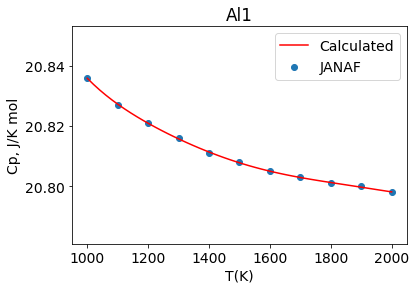

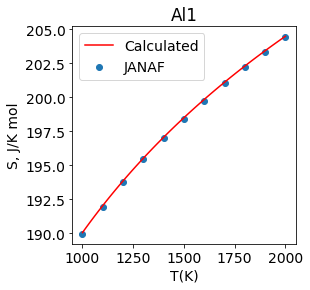

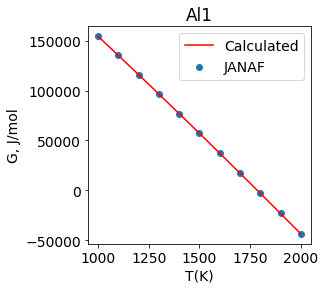

<Figure size 288x288 with 0 Axes>

In [34]:
show_first_diagram = True
for gas in gas_list:
    if gas in janaf_gases:
        create_Cp_plot(gas, minimum=1000, maximum=2000, save=True, show=show_first_diagram)
        create_S_plot(gas, minimum=1000, maximum=2000, save=True, show=show_first_diagram)
        create_G_plot(gas, minimum=1000, maximum=2000, save=True, show=show_first_diagram)
        show_first_diagram = False

 # Conversion Matrices

In [35]:
phase_list = [modelDB.get_phase(gas) for gas in basis_list]+[modelDB.get_phase(gas) for gas in nonbasis_list]
mu0 = np.array([gas.gibbs_energy(t,p) for gas in phase_list])
mu0_b = mu0[0:len(basis_list)]
mu0_s = mu0[len(basis_list):]
mu0_b, mu0_s

(array([-139576.48916321, -377016.68916321, -187917.224286  ,
        -411314.18916321, -268153.45745647, -113048.57798504,
        -425794.78916321, -248020.2035228 ,    2947.96087801]),
 array([ -239358.47979513,  -535009.00004546,  -742778.65868987,
        -1121975.68674421,  -487665.41073893,  -733198.65112929,
         -107100.24165414,  -794366.27062482, -1123114.15236185,
         -804746.67055885, -1361866.28562079,  -516062.29532508,
         -339821.77378281,  -759020.96498809,  -450676.37657327,
         -582051.51742418,  -398860.95816402, -1289054.80154124,
         -751557.60994699,  -476532.82783011,  -528549.08026967,
         -528095.4686191 ,  -958027.76759412,  -468970.86737986]))

In [36]:
C = np.array([gas.props['element_comp'][0] for gas in phase_list])

elm_sys_ind = np.where(np.sum(C,axis=0) > 0)[0]
elm_sys = [core.chem.PERIODIC_ORDER[i] for i in elm_sys_ind]
C = C[:,elm_sys_ind]
elm_sys, C

(['H', 'He', 'O', 'Ne', 'Mg', 'Al', 'Ar', 'Ca', 'Ti'],
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 1., 0., 0., 1., 0., 0., 0.],
        [1., 0., 1., 0., 0., 1., 0., 0., 0.],
        [1., 0., 2., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 2., 0., 0., 0.],
        [0., 0., 1., 0., 0., 2., 0., 0., 0.],
        [0., 0., 2., 0., 0., 2., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0., 1., 0.],
        [2., 0., 2., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 

In [37]:
Cb = C[0:len(basis_list),:]
Cs = C[len(basis_list):,:]
Cb, Cs

(array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.]]),
 array([[1., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 1., 0., 0., 1., 0., 0., 0.],
        [1., 0., 1., 0., 0., 1., 0., 0., 0.],
        [1., 0., 2., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1., 0., 0., 0.],
        [0., 0., 2., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 2., 0., 0., 0.],
        [0., 0., 1., 0., 0., 2., 0., 0., 0.],
        [0., 0., 2., 0., 0., 2., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0., 1., 0.],
        [2., 0., 2., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 1., 0.,

In [38]:
R = np.matmul(Cs, np.linalg.inv(Cb))
R

array([[1., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0., 1., 0., 0., 0.],
       [1., 0., 2., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 2., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 2., 0., 0., 0.],
       [0., 0., 1., 0., 0., 2., 0., 0., 0.],
       [0., 0., 2., 0., 0., 2., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 1., 0.],
       [2., 0., 2., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 1., 0., 1., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 2., 0., 0., 0., 0., 0., 0.],
       [2., 0., 0., 0., 0., 0., 0., 0., 0.],
       [2., 0., 2., 0., 1., 0., 0., 0., 0.],
       [2., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 2., 0., 0., 0., 0., 0., 0.],
       [0.

In [39]:
Q = np.exp(-(mu0_s - np.matmul(R,mu0_b))/(8.31446261815324*t))
lnQ = -(mu0_s - np.matmul(R,mu0_b))/(8.31446261815324*t)

In [40]:
Q

array([3.91178847e-01, 7.99009358e+02, 1.93379987e+09, 1.45750324e+15,
       5.45090340e+05, 3.21187432e+07, 2.20669038e-04, 4.85917392e+11,
       1.03199403e+16, 1.10491125e+07, 1.25526240e+14, 2.89660548e+02,
       8.19363560e-03, 1.04656804e+05, 6.09352348e+03, 1.11577267e+02,
       4.76547895e+03, 1.74962995e+11, 5.50887652e+08, 4.25317175e+00,
       3.60343138e+10, 4.76782345e+04, 9.52470144e+17, 1.22404477e-03])

In [41]:
lnQ

array([-0.93859041,  6.68337266, 21.38275275, 34.91550126, 13.20870682,
       17.28495032, -8.41884655, 26.90930447, 36.87285437, 16.21786066,
       32.46353594,  5.66870971, -4.80439757, 11.55844175,  8.71498176,
        4.71471733,  8.46915332, 25.88784033, 20.12704145,  1.447665  ,
       24.30773748, 10.77223027, 41.39783516, -6.70559452])

In [42]:
G_O2 = modelDB.get_phase("O2").gibbs_energy(1700, 1)
G_O1 = modelDB.get_phase("O1").gibbs_energy(1700, 1)
G_O2, G_O1

In [43]:
# Grxn = Gprod - Gelements
(G_O1 - 0.5*G_O2)/1000

### Some new code to try to create a better initial guess
- We will try to solve the mass action expressions in log space without mass balance constraints
- And, impose a "pseudo" mass balance constraint (sum of each element ~ order 1 mole, using non-negative least sqaures

In [44]:
RR = np.hstack((-R,np.eye(len(nonbasis_list))))
RR

array([[-1., -0., -0., -0., -0., -1., -0., -0., -0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1., -0., -1., -0., -0., -1., -0., -0., -0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1., -0., -1., -0., -0., -1., -0., -0., -0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1., -0., -2., -0., -0., -1., -0., -0., -0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-0., -0., -1., -0., -0., -1., -0., -0., -0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-0., -0., -2., -0., -0., -1., -0., -0., -0

The solution vector for the ln(X) of the basis species is then

In [45]:
soln = opt.nnls(RR, -lnQ)
y = -soln[0][:len(basis_list)]
soln, y

((array([ 7.55780503,  0.        ,  5.38611514,  0.        ,  0.        ,
         16.58546596,  0.        ,  6.57569561, 30.62560488, 25.0818614 ,
         22.84601347,  8.14663338,  0.        ,  8.76287427, 10.07274591,
         41.58977846, 11.64774258,  7.07030781,  3.30175511,  0.        ,
          6.29310103, 12.3622026 ,  1.38547842,  4.2289384 , 13.61531797,
          6.64645673,  0.        ,  0.37468375,  3.93845014, 11.70398254,
          0.        ,  0.        , 22.86393993]), 0.0),
 array([ -7.55780503,  -0.        ,  -5.38611514,  -0.        ,
         -0.        , -16.58546596,  -0.        ,  -6.57569561,
        -30.62560488]))

And, the above will serve as the initial guess for the solution of the mass action + mass balance system>

# Test Solution method for Eq #15

In [46]:
def sys_eqns(y, e, lnQ, R, Cb, Cs, print_species=False):
    nT = np.sum(e)
    prod = []
    for i, qq in enumerate(lnQ):
        sum = qq
        for j, yy in enumerate(y):
            sum += R[i,j]*yy
        prod.append(np.exp(sum))
    prod = np.array(prod)
    if print_species:
        print (nT*prod)
    #print (nT*np.matmul(Cb.T,np.exp(y)), nT*np.matmul(Cs.T,prod))
    f = nT*np.matmul(Cb.T,np.exp(y)) + nT*np.matmul(Cs.T,prod) - e
    df  = nT*np.matmul(np.diag(np.exp(y)), Cb) + nT*np.matmul(np.matmul(R.T, np.diag(prod)), Cs)
    return f, df

In [47]:
n_basis = len(basis_list)
n_nonbasis = len(nonbasis_list)
e = np.array([2]*n_basis)
sys_eqns(y, e, lnQ, R, Cb, Cs)

(array([118.24032767,  16.        , 196.31057492,  16.        ,
         38.85436106,  16.03970514,  16.        ,  16.72110418,
         16.0001487 ]),
 array([[217.03731794,   0.        , 210.18412617,   0.        ,
          40.50375022,  18.00521477,   0.        ,  36.66273282,
           0.        ],
        [  0.        ,  18.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ],
        [210.18412617,   0.        , 378.34273761,   0.        ,
          40.85428407,  36.07106285,   0.        ,  36.69601513,
          36.0001487 ],
        [  0.        ,   0.        ,   0.        ,  18.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ],
        [ 40.50375022,   0.        ,  40.85428407,   0.        ,
          40.85436106,   0.        ,   0.        ,   0.        ,
           0.        ],
        [ 18.00521477,   0.        ,  36.07106285,   0.        ,
           0.

In [48]:
result = opt.root(sys_eqns, y, args=(e, lnQ, R, Cb, Cs), method="lm", options={'col_deriv':True}, jac=True)
result

   cov_x: array([[ 6.44730757e-02, -6.28800920e-22,  3.08737828e-04,
         0.00000000e+00, -5.27582503e-06, -1.80581773e-04,
         0.00000000e+00, -3.93791241e-07, -2.33660360e-04],
       [-6.28800920e-22,  2.50000000e-01, -1.22705619e-27,
         0.00000000e+00, -4.13590305e-25,  1.62843691e-18,
        -0.00000000e+00,  2.64697796e-23, -1.17976566e-17],
       [ 3.08737828e-04, -1.22707314e-27,  4.74154267e+00,
         0.00000000e+00, -1.19900246e-07, -2.10129342e+00,
         0.00000000e+00, -1.15910003e-05, -3.73640558e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         2.50000000e-01, -0.00000000e+00, -0.00000000e+00,
         0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-5.27582503e-06, -4.13590305e-25, -1.19900246e-07,
         0.00000000e+00,  2.50000000e-01,  5.47305450e-08,
        -0.00000000e+00,  1.83028086e-11,  9.20337805e-08],
       [-1.80581773e-04,  1.62843691e-18, -2.10129342e+00,
         0.00000000e+00,  5.47305450e-08,

In [49]:
nT = np.sum(e)
print ('Basis species concentrations:')
print (nT*np.exp(result.x))
print ('Non-basis species concentrations:')
print ('Function value:', sys_eqns(np.array(result.x), e, lnQ, R, Cb, Cs, print_species=True))

Basis species concentrations:
[6.05033275e-02 2.00000000e+00 9.95156935e-10 2.00000000e+00
 1.99994488e+00 6.67776845e-01 2.00000000e+00 1.99999586e+00
 6.67752371e-01]
Non-basis species concentrations:
[8.78038327e-04 9.91537275e-11 2.39976495e-04 9.99967254e-09
 2.01242132e-05 6.55583533e-14 5.46678014e-06 6.65536255e-01
 7.81457799e-07 4.10659917e-06 8.66992350e-12 3.20285674e-08
 5.50809506e-05 3.88965712e-08 2.03829396e-08 2.06344605e-20
 9.69153506e-01 1.20841436e-14 6.19395609e-06 4.70272968e-10
 1.33030359e+00 2.62319640e-15 1.94403888e-03 3.72329127e-33]
Function value: (array([ 0.00000000e+00, -4.44089210e-16,  2.66453526e-15,  4.44089210e-16,
       -2.22044605e-16,  1.77635684e-15,  4.44089210e-16,  0.00000000e+00,
        2.22044605e-15]), array([[3.93831940e+00, 0.00000000e+00, 2.56550419e-04, 0.00000000e+00,
        5.51198472e-05, 1.11802492e-03, 0.00000000e+00, 4.10661651e-06,
        0.00000000e+00],
       [0.00000000e+00, 2.00000000e+00, 0.00000000e+00, 0.00000000e+

In [50]:
basis_list

['H1', 'He1', 'O1', 'Ne1', 'Mg1', 'Al1', 'Ar1', 'Ca1', 'Ti1']

# NEW: function to evaluate sympy free energy expressions

In [51]:
nT*np.exp(result.x)

array([6.05033275e-02, 2.00000000e+00, 9.95156935e-10, 2.00000000e+00,
       1.99994488e+00, 6.67776845e-01, 2.00000000e+00, 1.99999586e+00,
       6.67752371e-01])

In [52]:
def eval_expr(expr, t, p, e=np.sum(e)*np.exp(result.x)):
    
    global global_minimum, global_maximum, global_method, global_ncoeffs
    
    for i in range(0, len(n)):
        expr = expr.subs({'n'+str(i+1):e[i]})
    
    expr = expr.subs({'R':8.31446261815324})

    for i in range(0, len(mu)):
        expr = expr.subs({mu[i]:float(create_subbed_GPr_expression(basis_list[i], minimum=global_minimum, maximum=global_maximum, ncoeffs=global_ncoeffs, method=global_method).subs({'T':t, 'P':p}))})
        
    for gas in nonbasis_list:
        expr = expr.subs({'mu_sp_'+gas:float(create_subbed_GPr_expression(gas, minimum=global_minimum, maximum=global_maximum, ncoeffs=global_ncoeffs, method=global_method).subs({'T':t, 'P':p}))})
        
    return expr.subs({'T':t, 'P':p})

# helper function
def multiplyList(myList) : 
      
    # Multiply elements one by one 
    result = 1
    for x in myList: 
         result = result * x  
    return result

# Construct Solution Phase (coder)

In [53]:
c = len(elm_sys)
modelCD = coder.SimpleSolnModel(nc=c)

In [54]:
T = modelCD.get_symbol_for_t()
mu = modelCD.mu

In [55]:
R = sym.symbols('R')

In [56]:
n = modelCD.n
nT = modelCD.nT
X = (n/nT)
#X = (n/nT)*(P/(R*T)) # test
n, nT, X

⎛                                                  ⎡                    n₁    
⎜                                                  ⎢──────────────────────────
⎜                                                  ⎢n₁ + n₂ + n₃ + n₄ + n₅ + n
⎜                                                  ⎢                          
⎜                                                  ⎢                    n₂    
⎜                                                  ⎢──────────────────────────
⎜                                                  ⎢n₁ + n₂ + n₃ + n₄ + n₅ + n
⎜                                                  ⎢                          
⎜                                                  ⎢                    n₃    
⎜⎡n₁⎤                                              ⎢──────────────────────────
⎜⎢  ⎥                                              ⎢n₁ + n₂ + n₃ + n₄ + n₅ + n
⎜⎢n₂⎥                                              ⎢                          
⎜⎢  ⎥                                              ⎢

# Alternative formulation for G Eq(22)
This alternative but equivalent formulation speeds up code generation and compilation by a factor of 10  
Code size is also reduced by a factor of three

In [57]:
Galt = (n.transpose()*mu)[0]
Galt

In [58]:
S_config = 0
for i in range(0,c):
    S_config += X[i]*sym.log(X[i])
S_config *= -R*nT
Galt += - T*S_config # Galt

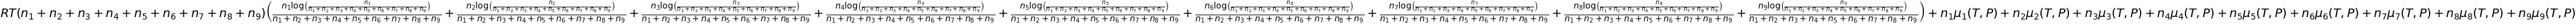

In [59]:
Galt

In [60]:
eval_expr(Galt, t=t, p=p)

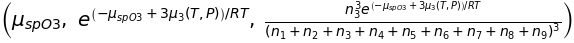

In [61]:
params = []
paramValues = {'T_r':298.15, 'P_r':1.0}
endmember_stoich = np.matmul(Cs, np.linalg.inv(Cb))

mu_list = []
Q_list = []
X_list = []

# additional stuff for Gorig
S_orig_config = sym.symbols('S_config')
mu_times_molfrac = 0
S_orig_config = 0

# loop through endmembers and derive mu, Q, X, and terms for Gorig and Galt
for i in range(0, len(endmember_stoich)):
    
    # define symbols for mu
    mu_endmember = sym.symbols('mu_sp_'+nonbasis_list[i])
    mu_list.append(mu_endmember)
    
    #params.append(('mu_sp_'+nonbasis_list[i], 'J', mu_endmember))
    #paramValues['mu_sp_'+nonbasis_list[i]] = mu0_s[i]
    #paramValues['mu_sp_'+nonbasis_list[i]] = reference_mu[nonbasis_list[i]]
    
    # calculate Q
    init_exp = mu_endmember
    for ii in range(0, len(endmember_stoich[i])):
        init_exp -= int(endmember_stoich[i][ii])*mu[ii]
    Q_endmember = sym.exp(-(init_exp)/R/T)
    Q_list.append(Q_endmember)

    # calculate X
    X_list_temp = []
    for ii in range(0, len(endmember_stoich[i])):
        if endmember_stoich[i][ii] != 0:
            if endmember_stoich[i][ii] == 1:
                X_list_temp += [X[ii]]
            else:
                X_list_temp += [X[ii]]*int(endmember_stoich[i][ii])
    X_endmember = Q_endmember*multiplyList(X_list_temp)
    X_list.append(X_endmember)
        
    # add expression to Galt
    expr = 0
    for ii in range(0, len(endmember_stoich[i])):
        expr += int(endmember_stoich[i][ii])*mu[ii]+int(endmember_stoich[i][ii])*R*T*sym.log(X[ii])
        
    ### TEST
    Galt -= X_endmember*expr # test
    #Galt += nT*X_endmember*expr # fixed Galt
    
    # extra expressions for Gorig
    mu_times_molfrac += mu_endmember*X_endmember
    S_orig_config += X_endmember*sym.log(X_endmember)
    

# display mu, Q, and X for the last looped endmember
mu_endmember, Q_endmember, X_endmember

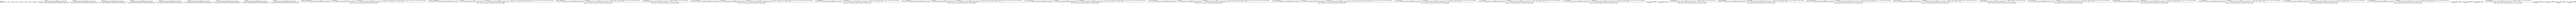

In [62]:
Galt

In [63]:
eval_expr(Galt, t=t, p=p)

In [64]:
#eval_expr(Q_endmember, t=t, p=p)

In [65]:
#[eval_expr(Q_endmember, t=temp, p=p) for temp in [500, 1000, 1500, 2000]]

In [66]:
#[eval_expr(X, t=t, p=p) for X in X_list]

In [67]:
#Galt

### "Gfinal" formulation attempt

In [68]:
Gfin = sum([n[i]*(mu[i] - R*T*sym.log(P) + R*T*sym.log(X[i]*P)) for i,x in enumerate(mu)])

In [69]:
# Gfin = (n.transpose()*mu)[0]
# Gfin

In [70]:
for i, endmember in enumerate(nonbasis_list):
    Gfin += nT*X_list[i]*(mu_list[i] - R*T*sym.log(P) + R*T*sym.log(X_list[i]*P))

In [71]:
#Gfin

### original formulation of G (test)

In [72]:
Gorig_ss = (n.transpose()*mu)[0] + nT*mu_times_molfrac
#Gorig_ss

In [73]:
#Gorig_ss

In [74]:
for i in range(0,c):
    S_orig_config += X[i]*sym.log(X[i])
S_orig_config *= -R*nT
#S_orig_config

In [75]:
Gorig = Gorig_ss - T*S_orig_config #Gorig
#Gorig

In [76]:
# substitute nonbasis mu symbols with GPr expressions
for i in range(0, len(endmember_stoich)):
    this_equation = create_subbed_GPr_expression(nonbasis_list[i], minimum=global_minimum, maximum=global_maximum, method=global_method, ncoeffs=global_ncoeffs, fit=global_fit)
    #Gorig = Gorig.subs({'mu_sp_'+nonbasis_list[i]:this_equation})
    Galt = Galt.subs({'mu_sp_'+nonbasis_list[i]:this_equation})
    #Gfin = Gfin.subs({'mu_sp_'+nonbasis_list[i]:this_equation})

In [77]:
#Galt

# NEW: Comparing results of original and alternate free energy expressions

In [78]:
# # original
float(eval_expr(Gorig, t=t, p=p))

In [79]:
# # alternate
float(eval_expr(Galt, t=t, p=p))

In [80]:
# # another alternate
# float(eval_expr(Gfin, t=t, p=p))

# Code the model

In [81]:
modelCD.add_expression_to_model(Galt, params) # Galt vs. Gorig

In [82]:
#modelCD.add_expression_to_model(Gfin, params) # test

In [83]:
modelCD.module = "gas_soln_t"

In [84]:
formula = ''
convert = []
test = []
for ind,elm in enumerate(elm_sys):
    formula += elm + '[' + elm + ']'
    convert.append('['+str(ind)+']=['+elm+']')
    test.append('['+str(ind)+'] >= 0.0')
formula, convert, test

('H[H]He[He]O[O]Ne[Ne]Mg[Mg]Al[Al]Ar[Ar]Ca[Ca]Ti[Ti]',
 ['[0]=[H]',
  '[1]=[He]',
  '[2]=[O]',
  '[3]=[Ne]',
  '[4]=[Mg]',
  '[5]=[Al]',
  '[6]=[Ar]',
  '[7]=[Ca]',
  '[8]=[Ti]'],
 ['[0] >= 0.0',
  '[1] >= 0.0',
  '[2] >= 0.0',
  '[3] >= 0.0',
  '[4] >= 0.0',
  '[5] >= 0.0',
  '[6] >= 0.0',
  '[7] >= 0.0',
  '[8] >= 0.0'])

In [85]:
modelCD.formula_string = formula
modelCD.conversion_string = convert
modelCD.test_string = test

In [86]:
endmembers = [basis+'_gas_species_t' for basis in basis_list]
paramValues, endmembers

({'T_r': 298.15, 'P_r': 1.0},
 ['H1_gas_species_t',
  'He1_gas_species_t',
  'O1_gas_species_t',
  'Ne1_gas_species_t',
  'Mg1_gas_species_t',
  'Al1_gas_species_t',
  'Ar1_gas_species_t',
  'Ca1_gas_species_t',
  'Ti1_gas_species_t'])

In [87]:
model_working_dir = "working"
!mkdir -p {model_working_dir}
%cd {model_working_dir}

/Users/graysonboyer/thermoSNCC/public_test/working


In [88]:
t_start_write = time.time()

In [89]:
modelCD.create_code_module(phase="IdealGas_t", params=paramValues, endmembers=endmembers, 
                           prefix="cy", module_type=module_type, silent=False, minimal_deriv_set=True)

Creating generic fast model code file string
Writing include file to working directory ...
Creating (once only) generic model calib codetemplate include file string
Creating (once only) generic model calib codetemplate code file string
Creating generic calib model code file string
Writing include file to working directory ...
Creating code blocks for standard state properties.
Creating calib code and include files ...
Writing include file to working directory ...
Writing code file to working directory ...
... done
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  gas_soln_t


True

# Inject some Python into the Cython wrapper
This injection deals with the speciation calculation (Eq #15), which must be done prior to any solution property calculation

In [90]:
%cd ..

/Users/graysonboyer/thermoSNCC/public_test


In [91]:
#sub_dict = {R:8.31446261815324, T:'t'}
sub_dict = {R:8.31446261815324, T:'t', P:'p'}

# create 'mu1(T, P): mu_end[i]' for i in basis list
for i in range(0, len(basis_list)):
    sub_dict.update({mu[i]:sym.symbols('mu_end['+str(i)+']')})
    
# create 'mu_sp_gas' for gas in nonbasis list
for i in range(0, len(nonbasis_list)):
    print(nonbasis_list[i])
    this_equation = create_subbed_GPr_expression(nonbasis_list[i], minimum=global_minimum, maximum=global_maximum, method=global_method, ncoeffs=global_ncoeffs, fit=global_fit)
    this_equation = this_equation.subs({T:'t', P:'p'})
    sub_dict.update({'mu_sp_'+nonbasis_list[i]:this_equation})
    
sub_dict

Al1H1
Al1H1O1_057
Al1H1O1_058
Al1H1O2
Al1O1
Al1O2
Al2
Al2O1
Al2O2
Ca1H1O1
Ca1H2O2
Ca1O1
H1Mg1
H1Mg1O1
H1O1
H1O2
H2
H2Mg1O2
H2O1
Mg1O1
O1Ti1
O2
O2Ti1
O3


{R: 8.31446261815324,
 T: 't',
 P: 'p',
 mu1(T, P): mu_end[0],
 mu2(T, P): mu_end[1],
 mu3(T, P): mu_end[2],
 mu4(T, P): mu_end[3],
 mu5(T, P): mu_end[4],
 mu6(T, P): mu_end[5],
 mu7(T, P): mu_end[6],
 mu8(T, P): mu_end[7],
 mu9(T, P): mu_end[8],
 'mu_sp_Al1H1': 2.76426360063116e-21*t**7 + 1.57527585884597e-17*t**6 - 4.11134595516673e-13*t**5 + 2.49747510449795e-9*t**4 - 7.79832874762599e-6*t**3 + 0.0148707297822744*t**2 - t*(3.22497420073636e-21*t**6 + 1.89033103061516e-17*t**5 - 5.13918244395841e-13*t**4 + 3.32996680599727e-9*t**3 - 1.1697493121439e-5*t**2 + 0.0297414595645487*t + 20.6235937128218*log(t) + 62.4472524076614) + 8.31446261815324*t*log(p) + 20.6235937128218*t + 252125.070888029,
 'mu_sp_Al1H1O1_057': -1.21320458007363e-19*t**7 + 1.53263177740441e-15*t**6 - 8.44964244131536e-12*t**5 + 2.66503550065132e-8*t**4 - 5.291854482451e-5*t**3 + 0.0684528329328476*t**2 - t*(-1.41540534341923e-19*t**6 + 1.83915813288529e-15*t**5 - 1.05620530516442e-11*t**4 + 3.55338066753509e-8*t**3

In [92]:
model_working_dir = "working"
!mkdir -p {model_working_dir}
%cd {model_working_dir}

/Users/graysonboyer/thermoSNCC/public_test/working


In [93]:
# sub_dict = { mu[0]:sym.symbols('mu_end[0]'), mu[1]:sym.symbols('mu_end[1]'), R:8.3143, T:'t'}
# sub_dict = dict(sub_dict, **paramValues)

if module_type == "calib":
    str_append = "_calib"
else:
    str_append = ""

sub_dict = dict(sub_dict, **{'T_r':298.15, 'P_r':1.0})
code_to_inject = \
'''
import math
import scipy.optimize as opt

def sys_eqns(y, e, lnQ, R, Cb, Cs, print_species=False):
    nT = np.sum(e)
    prod = []
    for i, qq in enumerate(lnQ):
        sum = qq
        for j, yy in enumerate(y):
            sum += R[i,j]*yy
        prod.append(np.exp(sum))
    prod = np.array(prod)
    if print_species:
        print (nT*prod)
    #print (nT*np.matmul(Cb.T,np.exp(y)), nT*np.matmul(Cs.T,prod))
    f = nT*np.matmul(Cb.T,np.exp(y)) + nT*np.matmul(Cs.T,prod) - e
    df  = nT*np.matmul(np.diag(np.exp(y)), Cb) + nT*np.matmul(np.matmul(R.T, np.diag(prod)), Cs)
    return f, df

class Storage:
    t = 0.0
    p = 0.0
    e = np.zeros(1)
    x = np.zeros(1)

def speciate(double t, double p, e):
    if Storage.t == t and Storage.p == p and np.array_equal(Storage.e, e):
        return Storage.x
    Storage.t = t
    Storage.p = p
    Storage.e = np.copy(e)
'''
code_to_inject += '    Cb = np.array(' + str(Cb.tolist()) + ')\n'
code_to_inject += '    Cs = np.array(' + str(Cs.tolist()) + ')\n'
code_to_inject += '    R = np.array(' + str(np.matmul(Cs, np.linalg.inv(Cb)).tolist()) + ')\n'
code_to_inject += '    Q = np.empty(' + str(Cs.shape[0]) + ')\n'
code_to_inject += '    mu_end = np.empty(' + str(Cb.shape[0]) + ')\n'

for i in range(0,Cb.shape[0]):
    code_to_inject += '    mu_end['+str(i)+'] = cy_IdealGas_t_gas_soln_t'+str_append+'_endmember_mu0('+str(i)+', t, p)\n'
for i,x in enumerate(Q_list):
    code_to_inject += '    Q['+str(i)+'] = ' + sym.pycode(x.subs(sub_dict)) + '\n'
# code_to_inject += '    Q[0] = ' + str(500373557) + '\n' # test
code_to_inject += \
'''

    # new y guess
    RR = np.hstack((-R,np.eye('''+str(len(nonbasis_list))+''')))
    lnQ = np.log(Q)
    soln = opt.nnls(RR, -lnQ)
    y = -soln[0][:'''+str(len(basis_list))+''']
    
    #print("lnQ", lnQ)
    
    # root solver
    result = opt.root(sys_eqns, y, args=(e, np.log(Q), R, Cb, Cs), method="lm", options={'col_deriv':True}, jac=True)
    # print(result)
    if not result.success:
        print("opt.root() was unsuccessful!")
    
    nT = np.sum(e)
    
    #print ('Basis species concentrations:')
    #print (nT*np.exp(result.x))
    #print ('Non-basis species concentrations:')
    #print ('Function value:', sys_eqns(np.array(result.x), e, np.log(Q), R, Cb, Cs, print_species=True))
    
    answ = []
    for i,xx in enumerate(result.x):
        if e[i] == 0:
            answ.append(0.0)
        else:
            answ.append(nT*np.exp(xx))
    Storage.x = np.array(answ)
    return Storage.x

'''
code_to_add = '    np_array = speciate(t, p, np_array)'

In [94]:
print(code_to_inject)


import math
import scipy.optimize as opt

def sys_eqns(y, e, lnQ, R, Cb, Cs, print_species=False):
    nT = np.sum(e)
    prod = []
    for i, qq in enumerate(lnQ):
        sum = qq
        for j, yy in enumerate(y):
            sum += R[i,j]*yy
        prod.append(np.exp(sum))
    prod = np.array(prod)
    if print_species:
        print (nT*prod)
    #print (nT*np.matmul(Cb.T,np.exp(y)), nT*np.matmul(Cs.T,prod))
    f = nT*np.matmul(Cb.T,np.exp(y)) + nT*np.matmul(Cs.T,prod) - e
    df  = nT*np.matmul(np.diag(np.exp(y)), Cb) + nT*np.matmul(np.matmul(R.T, np.diag(prod)), Cs)
    return f, df

class Storage:
    t = 0.0
    p = 0.0
    e = np.zeros(1)
    x = np.zeros(1)

def speciate(double t, double p, e):
    if Storage.t == t and Storage.p == p and np.array_equal(Storage.e, e):
        return Storage.x
    Storage.t = t
    Storage.p = p
    Storage.e = np.copy(e)
    Cb = np.array([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 

In [95]:
str_keys = [str(key) for key in sub_dict.keys()]
old_keys = [key for key in sub_dict.keys()]
new_sub_dict = {}
for i in range(0, len(sub_dict.keys())):
    new_sub_dict[str_keys[i]] = sub_dict[old_keys[i]]

In [96]:
if module_type == "calib":
    str_append = "_calib"
    str_append2 = "_dparam"
else:
    str_append = ""
    str_append2 = ""

with open('gas_soln_t.pyx', 'r') as f:
    fold = f.read()
    f.close()
st = [
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_g(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_dgdt(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_dgdp(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d2gdt2(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d2gdtdp(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d2gdp2(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d3gdt3(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d3gdt2dp(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d3gdtdp2(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d3gdp3(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_s(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_v(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_cv(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_cp(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_dcpdt(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_alpha(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_beta(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_K(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_Kp(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_dgdn(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d2gdndt(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d2gdndp(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d3gdndt2(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d3gdndtdp(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d3gdndp2(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d4gdndt3(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d4gdndt2dp(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d4gdndtdp2(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d4gdndp4(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d2gdn2(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d3gdn2dt(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d3gdn2dp(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d4gdn2dt2(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d4gdn2dtdp(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d4gdn2dp2(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d5gdn2dt3(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d5gdn2dt2dp(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d5gdn2dtdp2(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d5gdn2dp3(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d3gdn3(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d4gdn3dt(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d4gdn3dp(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d5gdn3dt2(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d5gdn3dtdp(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d5gdn3dp2(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d6gdn3dt3(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d6gdn3dt2dp(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d6gdn3dtdp2(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append+'_d6gdn3dp3(double t, double p, np_array):',
    'def cy_IdealGas_t_gas_soln_t'+str_append2+'_g(double t, double p, np_array, int index):',
    'def cy_IdealGas_t_gas_soln_t'+str_append2+'_dgdt(double t, double p, np_array, int index):',
    'def cy_IdealGas_t_gas_soln_t'+str_append2+'_dgdp(double t, double p, np_array, int index):',
    'def cy_IdealGas_t_gas_soln_t'+str_append2+'_d2gdt2(double t, double p, np_array, int index):',
    'def cy_IdealGas_t_gas_soln_t'+str_append2+'_d2gdtdp(double t, double p, np_array, int index):',
    'def cy_IdealGas_t_gas_soln_t'+str_append2+'_d2gdp2(double t, double p, np_array, int index):',
    'def cy_IdealGas_t_gas_soln_t'+str_append2+'_d3gdt3(double t, double p, np_array, int index):',
    'def cy_IdealGas_t_gas_soln_t'+str_append2+'_d3gdt2dp(double t, double p, np_array, int index):',
    'def cy_IdealGas_t_gas_soln_t'+str_append2+'_d3gdtdp2(double t, double p, np_array, int index):',
    'def cy_IdealGas_t_gas_soln_t'+str_append2+'_d3gdp3(double t, double p, np_array, int index):',
    'def cy_IdealGas_t_gas_soln_t'+str_append2+'_dgdn(double t, double p, np_array, int index):'
]
first = True
for x in st:
    if first:
        fnew = fold.replace(x, code_to_inject + x + '\n' + code_to_add)
        first = False
    else:
        fnew = fold.replace(x, x + '\n' + code_to_add)
    fold = fnew
with open('gas_soln_t.pyx', 'w') as f:
    f.write(fnew)
    f.close()

In [97]:
t_end_write = time.time()
print("Write time:", t_end_write-t_start_write, "seconds")
print("Write time:", (t_end_write-t_start_write)/60, "minutes")

t_start_compile = time.time()

Write time: 1123.0926780700684 seconds
Write time: 18.718211301167806 minutes


# Import the Solution Phase

In [98]:
import gas_soln_t
%cd ..

/Applications/anaconda/lib/python3.6/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /Users/graysonboyer/thermoSNCC/public_test/working/gas_soln_t.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


/Users/graysonboyer/thermoSNCC/public_test


In [99]:
t_end_compile = time.time()
print("Compile time:", t_end_compile-t_start_compile, "seconds")
print("Compile time:", (t_end_compile-t_start_compile)/60, "minutes")

Compile time: 799.8804950714111 seconds
Compile time: 13.33134158452352 minutes


In [100]:
if module_type == 'calib':
    modelGas = model.Database(database="CoderModule", calib=True, 
                              phase_tuple=('gas_soln_t', {'Gas':['IdealGas_t','solution']}))
else:
    modelGas = model.Database(database="CoderModule", calib=False, 
                              phase_tuple=('gas_soln_t', {'Gas':['IdealGas_t','solution']}))
Gas = modelGas.get_phase('Gas')

Solution phase code generated by the coder module does not yet provide information on solution species. Species are proxied by components.
Solution phase code generated by the coder module does not yet provide information on species properties. Species are proxied by components.


In [101]:
print (Gas.props['phase_name'])
print (Gas.props['formula'])
print (Gas.props['molwt'])
print (Gas.props['abbrev'])
print (Gas.props['endmember_num'])
print (Gas.props['endmember_name'])

IdealGas_t
['H' 'He' 'O' 'Ne' 'Mg' 'Al' 'Ar' 'Ca' 'Ti']
[ 1.0079   4.0026  15.9994  20.179   24.305   26.98154 39.948   40.08
 47.9    ]
Gas
9
['H1' 'He1' 'O1' 'Ne1' 'Mg1' 'Al1' 'Ar1' 'Ca1' 'Ti1']


In [102]:
t1 = time.time()
print(t1-t0, "seconds")
print((t1-t0)/60, "minutes")

2061.3088431358337 seconds
34.35514738559723 minutes


In [103]:
# record a flag file when finished
open("Finished","w+")

<_io.TextIOWrapper name='Finished' mode='w+' encoding='UTF-8'>

In [104]:
elm_sys

['H', 'He', 'O', 'Ne', 'Mg', 'Al', 'Ar', 'Ca', 'Ti']

In [105]:
basis_list

['H1', 'He1', 'O1', 'Ne1', 'Mg1', 'Al1', 'Ar1', 'Ca1', 'Ti1']

In [106]:
nonbasis_list

['Al1H1',
 'Al1H1O1_057',
 'Al1H1O1_058',
 'Al1H1O2',
 'Al1O1',
 'Al1O2',
 'Al2',
 'Al2O1',
 'Al2O2',
 'Ca1H1O1',
 'Ca1H2O2',
 'Ca1O1',
 'H1Mg1',
 'H1Mg1O1',
 'H1O1',
 'H1O2',
 'H2',
 'H2Mg1O2',
 'H2O1',
 'Mg1O1',
 'O1Ti1',
 'O2',
 'O2Ti1',
 'O3']

# NEW: Define the phase system

In [107]:
# Get a list of all MELTS phases that are accomodated
# by the current elm_sys and load them into the phase system

phs_sys = [Gas] # initialize with the ideal gas

db = model.Database(liq_mod='v1.0')

# loop through possible phases
for key in db.phases.keys():
    if key in ['O2', 'S2', 'H2', 'H2O']: # no need for 'preset' gases in MELTS
        continue
    this_phase = db.get_phase(key)
    #this_phase.endmember_names
    endmember_formulas = list(this_phase.props["formula"])
    endmember_elem_comp = [list(parse_formula(formula).keys()) for formula in endmember_formulas]
    endmember_elem_comp = list(set(itertools.chain.from_iterable(endmember_elem_comp)))
    if all(elem in elm_sys for elem in endmember_elem_comp):
        phs_sys.append(this_phase)

print([phase.phase_name for phase in phs_sys])

['IdealGas_t', 'Corundum', 'Lime', 'Periclase', 'Perovskite', 'Rutile', 'Brucite', 'Diaspore', 'Mg_Al_Spinel']


In [108]:
# # test
# db = model.Database(liq_mod='v1.0')
# Crn = db.get_phase("Crn")
# Crn.gibbs_energy(t, p)

# phs_sys = [Gas, Crn]

# Create additional phases

### Grossite (CaAl$_4$O$_7$)
"Calcium dialuminate"

In [109]:
if "Ca" in elm_sys and "Al" in elm_sys and "O" in elm_sys:

    grs_model = coder.StdStateModel()

    T = grs_model.get_symbol_for_t()
    P = grs_model.get_symbol_for_p()
    Tr = grs_model.get_symbol_for_tr()
    Pr = grs_model.get_symbol_for_pr()

    k0,k1,k2,k3 = sym.symbols('k0 k1 k2 k3')
    CpPr = k0+k1/sym.sqrt(T)+k2/T**2+k3/T**3
    STrPr,HTrPr = sym.symbols('S_TrPr H_TrPr')
    params = [('H_TrPr','J',HTrPr), ('S_TrPr','J/K',STrPr),
              ('k0','J/K-m',k0), ('k1','J-K^(1/2)-m',k1),
              ('k2','J-K/m',k2),  ('k3','J-K^2',k3)]

    GPr = HTrPr + sym.integrate(CpPr,(T,Tr,T)) - T*(STrPr + sym.integrate(CpPr/T,(T,Tr,T)))
    grs_model.add_expression_to_model(GPr, params)

#     VTrPr,a0,a1,a2,a3,a4 = sym.symbols('V_TrPr alpha_0 alpha_1 alpha_2 alpha_3 alpha_4')
#     params = [('V_TrPr', 'J/bar-m', VTrPr), ('alpha_0','1/bar',a0), ('alpha_1','1/bar^2',a1), ('alpha_2','1/K',a2),  ('alpha_3','1/K^2',a3), ('alpha_4','1/K^2',a4)]
#     # volumetric thermal expansion expression
#     # GB NOTE: does not include pressure-dependent params!
#     # Without compressibility, this probably only works at low P.
#     GPrToP = sym.integrate(VTrPr*(a0*T+a1+a2*T**-1+a3*T**-2+a4*T**-3),(P,Pr,P))
#     grs_model.add_expression_to_model(GPrToP, params)
    
    grs_model.set_module_name('grossite')

    model_working_dir = "working"
    !mkdir -p {model_working_dir}
    %cd {model_working_dir}

    param_dict = {'Phase': 'GROSSITE',
     'Formula': 'CA(1)AL(4)O(7)',
     'H_TrPr': -4007413.0, # Berman 1984
     'S_TrPr': 175.060, # Berman 1984
     'k0': 337.98, # Berman and Brown 1985
     'k1': -10.222E2, # Berman and Brown 1985
     'k2': -121.126E5, # Berman and Brown 1985
     'k3': 151.060E7, # Berman and Brown 1985
#      'V_TrPr': 89.057, # (ref 7 in table in Ottonello et al 2013)
#      'alpha_0': 0.0, # (ref 9 in table in Ottonello et al 2013)
#      'alpha_1': 275.400E-7, # (ref 9 in table in Ottonello et al 2013)
#      'alpha_2': 0.0, # (ref 9 in table in Ottonello et al 2013)
#      'alpha_3': 0.0, # (ref 9 in table in Ottonello et al 2013)
#      'alpha_4': 0.0, # (ref 9 in table in Ottonello et al 2013)
     'T_r': 298.15,
     'P_r': 1.0}

    phase_name = param_dict.pop('Phase', None).title()
    formula = param_dict.pop('Formula', None)
    result = grs_model.create_code_module(phase=phase_name, formula=formula,
                                      params=param_dict, module_type="fast")

    import grossite
    %cd ..
    
    # add grossite to phase system
    grst = phases.PurePhase(phase_classnm='cy_Grossite_grossite_',
                            abbrev="grst",
                            calib=False,
                            source="coder",
                            coder_module="grossite"
                           )
    
    phs_sys.append(grst)
    
    print(grossite.cy_Grossite_grossite_g(t,p))

else:
    print("Won't add grossite: missing Ca, Al, and/or O in basis")

/Users/graysonboyer/thermoSNCC/public_test/working
Creating (once only) generic fast model code file string
Creating (once only) generic model fast code template include file string
Creating (once only) generic model fast code template code file string
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  grossite


/Applications/anaconda/lib/python3.6/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /Users/graysonboyer/thermoSNCC/public_test/working/grossite.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


/Users/graysonboyer/thermoSNCC/public_test
-4708551.707137928


### Calcium Aluminate (CaAl$_2$O$_4$)

In [110]:
if "Ca" in elm_sys and "Al" in elm_sys and "O" in elm_sys:

    grs_model = coder.StdStateModel()

    T = grs_model.get_symbol_for_t()
    P = grs_model.get_symbol_for_p()
    Tr = grs_model.get_symbol_for_tr()
    Pr = grs_model.get_symbol_for_pr()

    k0,k1,k2,k3 = sym.symbols('k0 k1 k2 k3')
    CpPr = k0+k1/sym.sqrt(T)+k2/T**2+k3/T**3
    STrPr,HTrPr = sym.symbols('S_TrPr H_TrPr')
    params = [('H_TrPr','J',HTrPr), ('S_TrPr','J/K',STrPr),
              ('k0','J/K-m',k0), ('k1','J-K^(1/2)-m',k1),
              ('k2','J-K/m',k2),  ('k3','J-K^2',k3)]

    GPr = HTrPr + sym.integrate(CpPr,(T,Tr,T)) - T*(STrPr + sym.integrate(CpPr/T,(T,Tr,T)))
    grs_model.add_expression_to_model(GPr, params)

#     VTrPr,a0,a1,a2,a3,a4 = sym.symbols('V_TrPr alpha_0 alpha_1 alpha_2 alpha_3 alpha_4')
#     params = [('V_TrPr', 'J/bar-m', VTrPr), ('alpha_0','1/bar',a0), ('alpha_1','1/bar^2',a1), ('alpha_2','1/K',a2),  ('alpha_3','1/K^2',a3), ('alpha_4','1/K^2',a4)]
#     # volumetric thermal expansion expression
#     # GB NOTE: does not include pressure-dependent params!
#     # Without compressibility, this probably only works at low P.
#     GPrToP = sym.integrate(VTrPr*(a0*T+a1+a2*T**-1+a3*T**-2+a4*T**-3),(P,Pr,P))
#     grs_model.add_expression_to_model(GPrToP, params)
    
    grs_model.set_module_name('calciumaluminate')

    model_working_dir = "working"
    !mkdir -p {model_working_dir}
    %cd {model_working_dir}

    param_dict = {'Phase': 'CALCIUMALUMINATE',
     'Formula': 'CA(1)AL(2)O(4)',
     'H_TrPr': -2330292.0, # Berman 1984
     'S_TrPr': 115.348, # Berman 1984
     'k0': 227.04, # Berman and Brown 1985
     'k1': -16.691E2, # Berman and Brown 1985
     'k2': -5.608E5, # Berman and Brown 1985
     'k3': -8.554E7, # Berman and Brown 1985
#      'V_TrPr': 39.760, # (ref 6 in table in Ottonello et al 2013)
#      'alpha_0': 0.002590E-7, # (ref 5 in table in Ottonello et al 2013)
#      'alpha_1': 223.200E-7, # (ref 5 in table in Ottonello et al 2013)
#      'alpha_2': 0.0, # (ref 5 in table in Ottonello et al 2013)
#      'alpha_3': -1.0687, # (ref 5 in table in Ottonello et al 2013)
#      'alpha_4': 0.0, # (ref 5 in table in Ottonello et al 2013)
     'T_r': 298.15,
     'P_r': 1.0}

    phase_name = param_dict.pop('Phase', None).title()
    formula = param_dict.pop('Formula', None)
    result = grs_model.create_code_module(phase=phase_name, formula=formula,
                                      params=param_dict, module_type="fast")

    import calciumaluminate
    %cd ..
    
    # add calciumaluminate to phase system
    ca1 = phases.PurePhase(phase_classnm='cy_Calciumaluminate_calciumaluminate_',
                           abbrev="ca1",
                           calib=False,
                           source="coder",
                           coder_module="calciumaluminate"
                          )
    phs_sys.append(ca1)
    
    print(calciumaluminate.cy_Calciumaluminate_calciumaluminate_g(t,p))

else:
    print("Won't add calciumaluminate: missing Ca, Al, and/or O in basis")

/Users/graysonboyer/thermoSNCC/public_test/working
Creating (once only) generic fast model code file string
Creating (once only) generic model fast code template include file string
Creating (once only) generic model fast code template code file string
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  calciumaluminate


/Applications/anaconda/lib/python3.6/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /Users/graysonboyer/thermoSNCC/public_test/working/calciumaluminate.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


/Users/graysonboyer/thermoSNCC/public_test
-2763973.003952661


### Hibonite (CaAl$_{12}$O$_{19}$)
"Calcium hexaluminate"

In [111]:
if "Ca" in elm_sys and "Al" in elm_sys and "O" in elm_sys:

    hib_model = coder.StdStateModel()

    T = hib_model.get_symbol_for_t()
    P = hib_model.get_symbol_for_p()
    Tr = hib_model.get_symbol_for_tr()
    Pr = hib_model.get_symbol_for_pr()

    a,c,f,h = sym.symbols('a c f h')
    CpPr = a + c*T**-2+f*T**-0.5+h*T**-1
    STrPr,HTrPr = sym.symbols('S_TrPr H_TrPr')
    params = [('H_TrPr','J',HTrPr), ('S_TrPr','J/K',STrPr),
              ('a','J/K-m',a), ('c','',c), ('f','',f),  ('h','',h)]

    GPr = HTrPr + sym.integrate(CpPr,(T,Tr,T)) - T*(STrPr + sym.integrate(CpPr/T,(T,Tr,T)))
    hib_model.add_expression_to_model(GPr, params)

#     VTrPr,a0,a1,a2,a3,a4 = sym.symbols('V_TrPr alpha_0 alpha_1 alpha_2 alpha_3 alpha_4')
#     params = [('V_TrPr', 'J/bar-m', VTrPr), ('alpha_0','1/bar',a0), ('alpha_1','1/bar^2',a1), ('alpha_2','1/K',a2),  ('alpha_3','1/K^2',a3), ('alpha_4','1/K^2',a4)]
#     # volumetric thermal expansion expression
#     # GB NOTE: does not include pressure-dependent params!
#     # Without compressibility, this probably only works at low P.
#     GPrToP = sym.integrate(VTrPr*(a0*T+a1+a2*T**-1+a3*T**-2+a4*T**-3),(P,Pr,P))
#     hib_model.add_expression_to_model(GPrToP, params)
    
    hib_model.set_module_name('hibonite')

    model_working_dir = "working"
    !mkdir -p {model_working_dir}
    %cd {model_working_dir}

    param_dict = {'Phase': 'HIBONITE',
     'Formula': 'CA(1)AL(12)O(19)',
     'H_TrPr': -10724605.0, # Berman 1984
     'S_TrPr': 368.719, # Berman 1984
     'a': 973.423, # Berman and Brown 1985
     'c': -5517950.0, # Berman and Brown 1985
     'f': -3135.46, # Berman and Brown 1985
     'h': -63511.12, # Berman and Brown 1985
#      'V_TrPr': 176.729, # (ref 10 in table in Ottonello et al 2013)
#      'alpha_0': 0.0, # (ref 8 in table in Ottonello et al 2013)
#      'alpha_1': 210.000E-7, # (ref 8 in table in Ottonello et al 2013)
#      'alpha_2': 0.0, # (ref 8 in table in Ottonello et al 2013)
#      'alpha_3': 0.0, # (ref 8 in table in Ottonello et al 2013)
#      'alpha_4': 0.0, # (ref 8 in table in Ottonello et al 2013)
     'T_r': 298.15,
     'P_r': 1.0}

    phase_name = param_dict.pop('Phase', None).title()
    formula = param_dict.pop('Formula', None)
    result = hib_model.create_code_module(phase=phase_name, formula=formula,
                                      params=param_dict, module_type="fast")

    import hibonite
    %cd ..
    
    # add hibonite to phase system
    hib = phases.PurePhase(phase_classnm='cy_Hibonite_hibonite_',
                           abbrev="hib",
                           calib=False,
                           source="coder",
                           coder_module="hibonite"
                          )
              
    phs_sys.append(hib)
    
    print(hibonite.cy_Hibonite_hibonite_g(t,p))

else:
    print("Won't add hibonite: missing Ca, Al, and/or O in basis")

/Users/graysonboyer/thermoSNCC/public_test/working
Creating (once only) generic fast model code file string
Creating (once only) generic model fast code template include file string
Creating (once only) generic model fast code template code file string
Creating include file ...
... done!
Creating code file ...
... done
Writing include file to working directory ...
Writing code file to working directory ...
Writing pyxbld file to working directory ...
writing pyx file to working directory ...
Compiling code and Python bindings ...
Success! Import the module named  hibonite


/Applications/anaconda/lib/python3.6/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /Users/graysonboyer/thermoSNCC/public_test/working/hibonite.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


/Users/graysonboyer/thermoSNCC/public_test
-12435022.840954367


# Perform Equilibrium Calculation

In [112]:
# Cameron 1973 "ABUNDANCES OF THE ELEMENTS IN THE SOLAR SYSTEM"
# abundances normalized to Si=1e6
solar_dict = {"H":3.18e10,  #1
              "He":2.21e9,  #2
              "C":1.18e7,   #6
              "N":3.74e6,   #7
              "O":2.15e7,   #8
              "F":24500,    #9
              "Ne":3.44e6,  #10
              "Na":6.0e4,   #11
              "Mg":1.061e6, #12
              "Al":8.5e4,   #13
              "Si": 1.00e6, #14
              "P":9600,     #15
              "S":5.0e5,    #16
              "Cl":5700,    #17
              "Ar":1.172e5, #18
              "K":4200,     #19
              "Ca":7.21e4,  #20
              "Ti":2775,    #22
              "Cr":1.27e4,  #24
              "Mn":9300,    #25
              "Fe":8.3e5,   #26
              "Co":2210,    #27
              "Ni":4.80e4,  #28
             }

# Anders and Grevesse 1989
solar_dict = {"H":2.79e10,  #1
              "He":2.72e9,  #2
              "C":1.01e7,   #6
              "N":3.13e6,   #7
              "O":2.38e7,   #8
              "F":843,      #9
              "Ne":3.44e6,  #10
              "Na":5.74e4,  #11
              "Mg":1.074e6, #12
              "Al":8.49e4,  #13
              "Si":1e6,     #14
              "P":1.04e4,   #15
              "S":5.15e5,   #16
              "Cl":5240,    #17
              "Ar":1.01e5,  #18
              "K":3770,     #19
              "Ca":6.11e4,  #20
              "Ti":2400,    #22
              "Cr":1.35e4,  #24
              "Mn":9550,    #25
              "Fe":9.00e5,  #26
              "Co":2250,    #27
              "Ni":4.93e4,  #28
             }


# # Lodders 2003
# solar_dict = {"H":2.884e10, #1
#               "He":2.288e9, #2
#               "C":7.079e6,  #6
#               "N":1.950e6,  #7
#               "O":1.413e7,  #8
#               "F":841.1,    #9
#               "Ne":2.148e6, #10
#               "Na":5.751e4, #11
#               "Mg":1.020e6, #12
#               "Al":8.410e4, #13
#               "Si":1e6,     #14
#               "P":8373,     #15
#               "S":4.449e5,  #16
#               "Cl":5237,    #17
#               "Ar":1.025e5, #18
#               "K":3692,     #19
#               "Ca":6.287e4, #20
#               "Ti":2422,    #22
#               "Cr":1.286e4, #24
#               "Mn":9168,    #25
#               "Fe":8.380e5, #26
#               "Co":2323,    #27
#               "Ni":4.780e4, #28
#              }

In [113]:
solar_comp = np.array([solar_dict[elm] for elm in elm_sys])
print(elm_sys)
print(solar_comp)

['H', 'He', 'O', 'Ne', 'Mg', 'Al', 'Ar', 'Ca', 'Ti']
[2.790e+10 2.720e+09 2.380e+07 3.440e+06 1.074e+06 8.490e+04 1.010e+05
 6.110e+04 2.400e+03]


In [114]:
pred = Gas.gibbs_energy(t, p, mol=np.array([2]*len(basis_list)))
pred

# NEW: plot free energy as a function of T

Blue line: ideal gas

Blue Dot: ideal gas at this T and P

Orange line: corundum (Berman)

**The plot below assumes unity among elements in the gas phase.**

In [115]:
# import matplotlib.pyplot as plt
# %matplotlib inline

# db = model.Database(liq_mod='v1.0')
# this_phase = db.get_phase("Crn")
# this_phase.gibbs_energy(t, p)

# temps = np.linspace(1000, 2000, 200)
# gibbs = [Gas.gibbs_energy(temp, p, mol=np.array([1]*len(basis_list))) for temp in temps]
# this_phase_gibbs = [this_phase.gibbs_energy(temp, p) for temp in temps]

# plt.plot(temps, gibbs)
# plt.plot(temps, this_phase_gibbs)
# plt.plot(t, Gas.gibbs_energy(t, p, mol=np.array([1]*len(basis_list))), 'bo')
# plt.ylabel('Gibbs energy, joules')
# plt.xlabel('Temperature, K')

# plt.show()

**The plot below uses solar elemental abundance for the ideal gas phase**

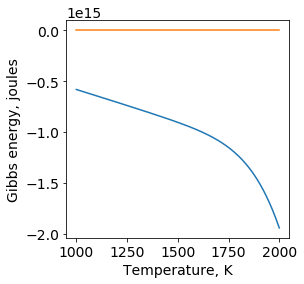

In [116]:
db = model.Database(liq_mod='v1.0')
this_phase = db.get_phase("Crn")
this_phase.gibbs_energy(t, p)

temps = np.linspace(1000, 2000, 200)
gibbs = [Gas.gibbs_energy(temp, p, mol=solar_comp) for temp in temps]
this_phase_gibbs = [this_phase.gibbs_energy(temp, p) for temp in temps]

plt.plot(temps, gibbs)
plt.plot(temps, this_phase_gibbs)
#plt.plot(t, Gas.gibbs_energy(t, p, mol=solar_comp), 'bo')
plt.ylabel('Gibbs energy, joules')
plt.xlabel('Temperature, K')

plt.show()

In [120]:
t0 = time.time()
equil = equilibrate.Equilibrate(elm_sys, phs_sys)
state = equil.execute(1700, 1e-5, bulk_comp=solar_comp, debug=0)
state.print_state()
t1 = time.time()
print(t1-t0, "seconds")
print((t1-t0)/60, "minutes")

No check made for phase separation.
 
T =    1426.85 °C, P =        0.0 MPa
IdealGas_t      moles: 30648342642.929363 grams: 39488060839.167
             H1 form:  H              X:  0.9103  wt%    TiO2    0.00
            He1 form:  He             X:  0.0887  wt%   Al2O3    0.00
             O1 form:  O              X:  0.0008  wt%     MgO    0.02
            Ne1 form:  Ne             X:  0.0001  wt%     CaO    0.00
            Mg1 form:  Mg             X:  0.0000  wt%     H2O   99.98
            Al1 form:  Al             X:  0.0000  
            Ar1 form:  Ar             X:  0.0000  
            Ca1 form:  Ca             X:  0.0000  
            Ti1 form:  Ti             X:  0.0000  
Corundum        affn:     997.61
Lime            affn:   73972.45
Periclase       affn:  109077.84
Perovskite      moles: 262.138289 grams: 35645.093
Rutile          affn:   14617.78
Brucite         affn:  432201.80
Diaspore        affn:  184042.65
Mg_Al_Spinel    affn:   75268.58
Grossite        affn:  

In [118]:
basis_list, nonbasis_list

(['H1', 'He1', 'O1', 'Ne1', 'Mg1', 'Al1', 'Ar1', 'Ca1', 'Ti1'],
 ['Al1H1',
  'Al1H1O1_057',
  'Al1H1O1_058',
  'Al1H1O2',
  'Al1O1',
  'Al1O2',
  'Al2',
  'Al2O1',
  'Al2O2',
  'Ca1H1O1',
  'Ca1H2O2',
  'Ca1O1',
  'H1Mg1',
  'H1Mg1O1',
  'H1O1',
  'H1O2',
  'H2',
  'H2Mg1O2',
  'H2O1',
  'Mg1O1',
  'O1Ti1',
  'O2',
  'O2Ti1',
  'O3'])